<a href="https://colab.research.google.com/github/rodrigoromanguzman/Actividades_Aprendizaje-/blob/main/A3a_DL_TC5033_embeddings_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TC 5033
### Word Embeddings

<br>

#### Activity 3a: Exploring Word Embeddings with GloVe and Numpy
<br>

- Objective:
    - To understand the concept of word embeddings and their significance in Natural Language Processing.
    - To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
    - To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

- Instructions:
    - Download GloVe pre-trained vectors from the provided link in Canvas, the official public project:
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
    https://nlp.stanford.edu/data/glove.6B.zip

    - Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
    - PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

    - Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

- Evaluation Criteria:

    - Code Quality (40%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    
   - Functionality (60%): All functions should work as intended, without errors.
       - Visualization of PCA and t-SNE (10% each for a total of 20%)
       - Similarity function (20%)
       - Analogy function (20%)
|



#### Import libraries

In [1]:
# Import libraries
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import pickle

# Libraries for reading file from gdrive
from google.colab import drive

plt.style.use('ggplot')

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load file

<h3>We will using the 50-dimensional GloVe word embedding database.</h3>

In [3]:
# PATH = '/media/pepe/DataUbuntu/Databases/glove_embeddings/glove.6B.200d.txt'
# PATH = '/media/pepe/DataUbuntu/Databases/glove_embeddings/glove.6B.50d.txt'
PATH = '/content/drive/My Drive/glove.6B.50d.txt'
emb_dim = 50

<h2>Create a dictionary where each word's name serves as the key and its corresponding embedded vector as the value.</h2>
<p>The text document follows a specific format: each line begins with a word, followed by its associated vector values separated by spaces, which we aim to store in the dictionary.</p>

In [4]:
# Create dictionary with embeddings
def create_emb_dictionary(path):
  dictionary = {}
  with open(PATH, 'r') as file:
    for line in file:
        # Split the line where a newline character is found
        line = line.strip()  # Remove leading/trailing whitespace, including newline characters
        words = line.split() # Split the elements of the line by their space
        if len(words)>=2:
          key = words[0] #Take the first element which is the word as a key
          value =  np.array(words[1:],dtype=float) #Use the rest of the elements as the numpy values
          dictionary[key] = value #Store the values in the dictionary
  return dictionary

<h3>Store the dictionary into a variable we can use later</h3>

In [5]:
# create dictionary
embeddings_dict = create_emb_dictionary(PATH)

<h2>
We serialize the embeddings_dict dictionary into a binary file for efficient storage and later retrieval, simplifying the process of accessing the dictionary's data.</h2>

In [6]:
# Serialize
with open('embeddings_dict_50D.pkl', 'wb') as f:
    pickle.dump(embeddings_dict, f)

# Deserialize
# with open('embeddings_dict_200D.pkl', 'rb') as f:
#     embeddings_dict = pickle.load(f)

#### See some embeddings

In [7]:
# Show some
def show_n_first_words(path, n_words):
        with open(path, 'r') as f:
            for i, line in enumerate(f):
                print(line.split(), len(line.split()[1:]))
                if i>=n_words: break

In [8]:
show_n_first_words(PATH, 5)

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581'] 50
[',', '0.013441', '0.23682', '-0.16899', '0.40951', '0.63812', '0.47709', '-0.42852', '-0.55641', '-0.364', '-0.23938', '0.13001', '-0.063734', '-0.39575', '-0.48162', '0.23291', '0.090201', '-0.13324', '0.078639', '-0.41634', '-0.15428', '0.10068', '0.48891', '0.31226', '-0.1252', '-0.037512', '-1.5179', '0.12612', '-0.02442', '-0.042961', '-0.28351', '3.5416', '-0.11956', '-0.014533', '-0.

### Plot some embeddings

<h2>Embeddings Visualization Function</h2>
<p>This function takes a dictionary as input and extracts the necessary data for graphing. To visualize the initially multidimensional vectors effectively, dimensionality reduction is applied using the provided dimensionality reduction method, such as PCA or TSNE. The resulting reduced-dimensional vectors are then plotted for the specified words in the 'words2show' parameter.</p>

In [9]:
def plot_embeddings(emb_path, words2show, emb_dim, embeddings_dict, dimensionReduce=PCA):
    dimensionReduce = dimensionReduce(n_components=2)
    transformed_data = dimensionReduce.fit_transform(np.array(list(embeddings_dict.values())))

    # Create a dictionary with the transformed data
    transformed_dict = {word: transformed_data[i] for i, word in enumerate(embeddings_dict.keys())}

    # Scatter plot the transformed data in 2D
    plt.figure(figsize=(10, 10))
    plot_values = np.array([transformed_dict[word] for word in words2show])
    plt.scatter(plot_values[:, 0], plot_values[:, 1], marker='o', s=50)

    # Add labels to the points
    for word in words2show:
        plt.annotate(word, transformed_dict[word], fontsize=10)

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('dimensionReduce Plot in 2D')
    plt.show()



In [10]:
words= ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips',
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']


<h2>PCA reduction visualization</h2>

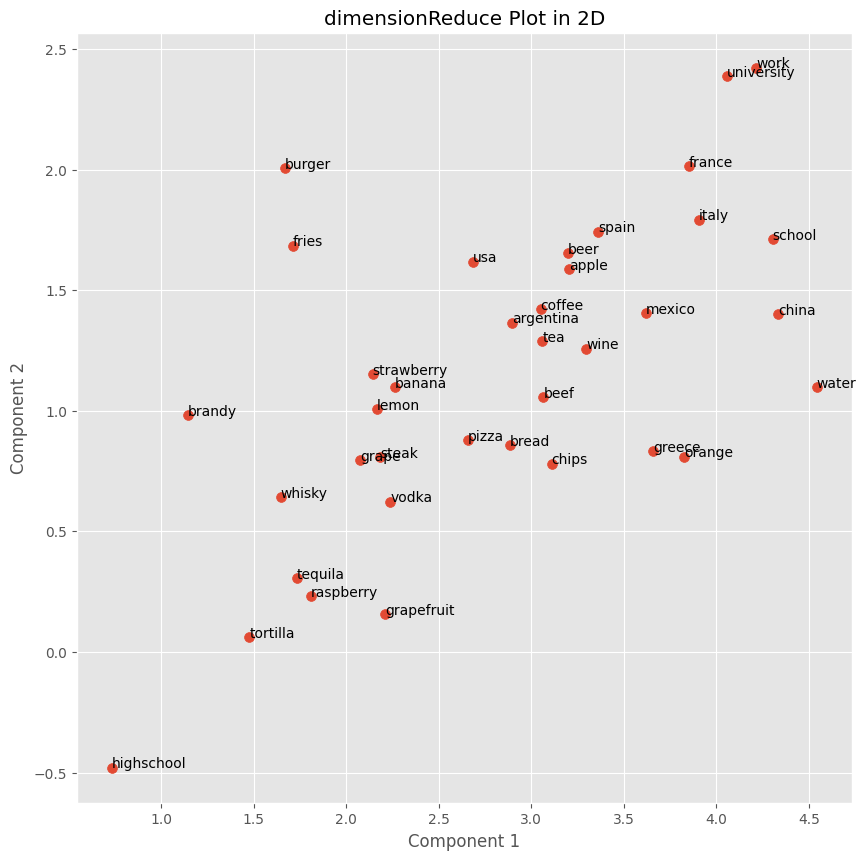

In [11]:
plot_embeddings(PATH, words, emb_dim, embeddings_dict,PCA)

<h2>PCA Graph Insights</h2>
<p>Initially, the dots on the graph may appear scattered without a clear pattern. Upon closer examination, intuitive patterns emerge; for instance, 'work' and 'university' are closely positioned, while 'burger' and 'fries' exhibit a similar proximity. Likewise, 'coffee,' 'beer,' and 'wine' cluster closely together. These observations suggest that it's possible to cluster these points, revealing how categories are inherently related and tend to group together based on their semantic relationships.</p>

<h2>TSNE reduction visualization</h2>

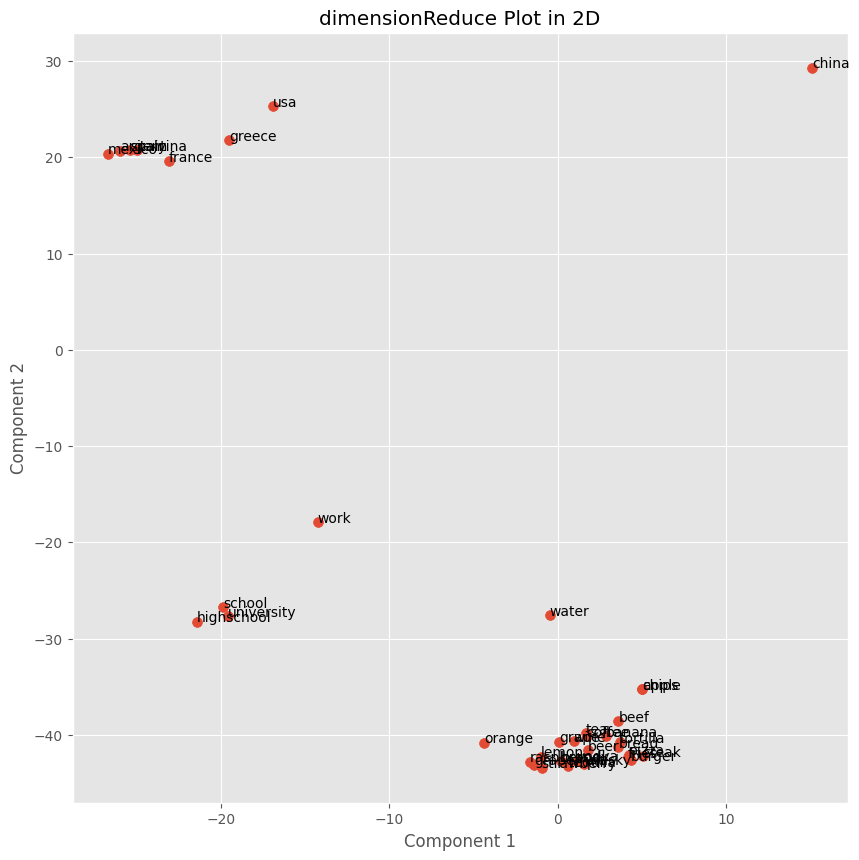

In [20]:
# t-SNE dimensionality reduction for visualization

# TSNE is a very expensive algorithm. So we have to reduce the size
# of the dictionary before passing it to the plot function
reduced_dictionary = dict(list(embeddings_dict.items())[:1000])

# We just make sure that the words we need will be there
for i in words:
  reduced_dictionary[i] = embeddings_dict[i]
embeddings = plot_embeddings(PATH, words, emb_dim, reduced_dictionary,TSNE)

<h2>TSNE Graph Analysis</h2>
<p>Despite not utilizing the entire dataset for TSNE, the results indicate a commendable separation of clusters. Notably, TSNE differs from PCA by providing more distinct and well-separated clusters. These clusters can be broadly categorized into three intuitive groups: consumables (food, water), locations (work, high school, school), and geographical entities (France, Greece, etc.).</p>


### Let us compute analogies

<h2>Computing Analogies with GloVe</h2>
<p>As outlined in the GloVe article, "Global Vectors for Word Representation," computing analogies involves answering questions of the form "a is to b as c is to ?" by finding the word 'd' whose representation $w_4$ is closest to $$w_2 - w_1 + w_3$$ based on cosine similarity.</p>
<p>This approach mirrors the one we employ, with a crucial detail to note: when searching for the closest element, we ensure that 'w1,' 'w2,' and 'w3' are not included in the search criteria, which is achieved through the condition (key not in [word1, word2, word3]).</p>

In [13]:
# analogy
def analogy(word1, word2, word3, embeddings_dict):
  # Define a variable for storing the current minimum, initialize it to infinity
  current_minimum = float("inf")
  # Define the target vector  𝑤4 = 𝑤2−𝑤1+𝑤3
  target_vector = embeddings_dict[word2] - embeddings_dict[word1] + embeddings_dict[word3]
  word4 = "NONE"
  for key, current in embeddings_dict.items():
    # Compute the distance from the current word vector to the target vector
    word3_current_distance = np.linalg.norm(target_vector - current)
    # Check if the distance is less than the previous one stored and
    # make sure the word is not the same as word1, word2 nor word3
    if(word3_current_distance < current_minimum and (key not in [word1, word2, word3])):
      current_minimum =  word3_current_distance
      word4 = key
  return word4

In [14]:
analogy('man', 'king', 'woman', embeddings_dict)

'queen'

In [15]:
analogy('paris', 'france', 'rome', embeddings_dict)

'italy'

In [21]:
analogy('cat', 'kitten', 'dog', embeddings_dict)

'puppy'

<h2>Find most similar words</h2>

<p>This algorithm finds the top N most similar words to a given word in an embeddings dictionary based on the Euclidean distance between word vectors. It creates a list of tuples, each containing a word and its distance to the target word, sorts them by distance, and returns the top N similar words, excluding the target word itself.</p>

In [16]:
# most similar
def find_most_similar(word, embeddings_dict, top_n=10):

  # Create a copy of the key, vector elements of the dictionary
  key_vector_distance = list(embeddings_dict.items())
  for idx,(key, current) in enumerate(embeddings_dict.items()):

    # Compute the distance between the word and all the other vectors
    distance_word_current = np.linalg.norm(embeddings_dict[word] - current)

    # Save the distance into as an element of the tuple
    key_vector_distance[idx] = key_vector_distance[idx] + (distance_word_current,)

  # Sort by the last element of the tuple
  sorted_list = sorted(key_vector_distance, key=lambda x: x[-1])

  # Return the last 10 elements without taking the first one which is the
  # actual word
  return sorted_list[1:11:]

In [17]:
most_similar = find_most_similar('mexico', embeddings_dict)

In [18]:
for i, w in enumerate(most_similar, 1):
    print(f'{i} ---> {w[0]}')

1 ---> venezuela
2 ---> peru
3 ---> mexican
4 ---> chile
5 ---> colombia
6 ---> puerto
7 ---> rico
8 ---> guatemala
9 ---> panama
10 ---> costa


In [22]:
most_similar = find_most_similar('pizza', embeddings_dict)

In [23]:
for i, w in enumerate(most_similar, 1):
    print(f'{i} ---> {w[0]}')

1 ---> sandwich
2 ---> sandwiches
3 ---> snack
4 ---> bakery
5 ---> fries
6 ---> burgers
7 ---> burger
8 ---> bagel
9 ---> restaurant
10 ---> diner


In [24]:
most_similar = find_most_similar('dog', embeddings_dict)

In [25]:
for i, w in enumerate(most_similar, 1):
    print(f'{i} ---> {w[0]}')

1 ---> cat
2 ---> dogs
3 ---> puppy
4 ---> rabbit
5 ---> pet
6 ---> horse
7 ---> pig
8 ---> pack
9 ---> cats
10 ---> bite


<h1>General Observations about Activity</h1>
<p>Exploring the word embedding representation of our vocabulary provides us with a comprehensive record of various linguistic features embedded within these word vectors. This rich information allows us to leverage a wide range of vector manipulation techniques and tools.</p>
<p>One particularly striking revelation is the capacity to mathematically capture what we often perceive as linguistic intuition. It demonstrates that the seemingly abstract and intuitive aspects of language can be quantified and analyzed statistically. This insight not only sheds light on the mathematical underpinnings of language but also underscores the statistical nature underlying numerous natural phenomena, including the organization of human ideas and concepts.</p>
<p>In essence, this activity highlights the bridge between linguistic intuition and mathematical representation, offering new avenues for understanding and analyzing language in a data-driven manner.</p>